# Classification Metrics: Precision, Recall, F1, ROC AUC, and PR AUC

When evaluating a classification model accuracy alone isn’t enough. To better understand how well your model is performing, we need to dig deeper by understanding metrics like **precision**, **recall**, **F1 score**, and performance curves like **ROC** and **Precision-Recall (PR)**.

We'll start by using the same classifier as in the Logistic Regression post.

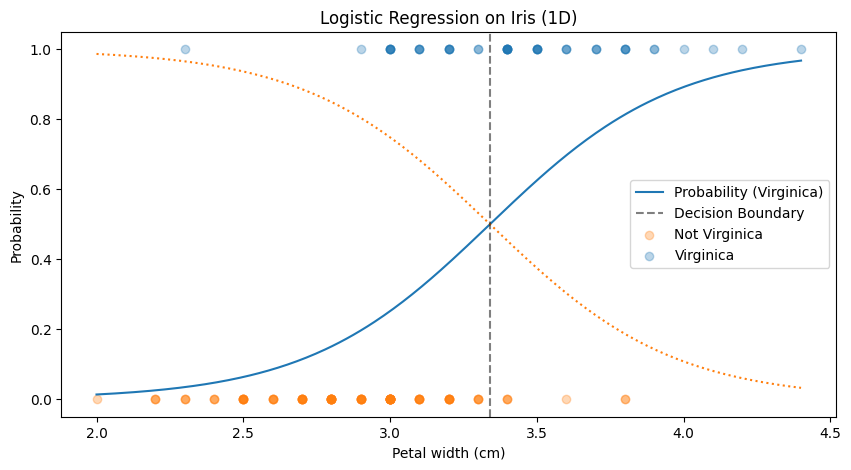

In [63]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X = iris["data"][:,1].reshape(-1,1)
y = (iris["target"] == 0).astype(int)

log_reg = LogisticRegression()
log_reg.fit(X,y)

X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_prob = log_reg.predict_proba(X_test)

plt.figure(figsize=(10,5))
plt.plot(X_test, y_prob[:, 1], label="Probability (Virginica)")
plt.plot(X_test, y_prob[:, 0], ":")
plt.axvline(log_reg.intercept_ / -log_reg.coef_[0], color="k", alpha=0.5, linestyle="--", label="Decision Boundary")

X_class0 = X[y == 0]
X_class1 = X[y == 1]
plt.scatter(X_class0, np.zeros(X_class0.shape[0]), c='tab:orange', label="Not Virginica", alpha=0.3,)
plt.scatter(X_class1, np.ones(X_class1.shape[0]), c='tab:blue', label="Virginica", alpha=0.3)

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.title("Logistic Regression on Iris (1D)")
plt.legend()
plt.show()

## The Confusion Matrix

Everything starts with the **confusion matrix**, which keeps track of four outcomes in binary classification:

* **True Positives (TP)**: predicted positive, actually positive
* **False Positives (FP)**: predicted positive, actually negative
* **False Negatives (FN)**: predicted negative, actually positive
* **True Negatives (TN)**: predicted negative, actually negative

From these four numbers, we can define our most important metrics.

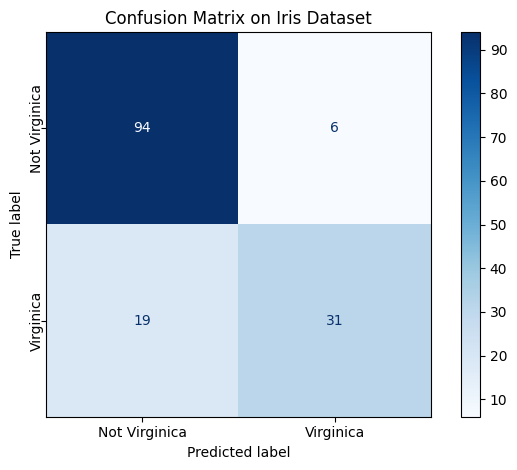

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred = log_reg.predict(X)

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Virginica", "Virginica"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)

# Rotate only y-axis tick labels and center them
for label in ax.get_yticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('center')
    label.set_horizontalalignment('center')  # You can try 'right' if 'center' isn't visually pleasing

plt.title("Confusion Matrix on Iris Dataset")
plt.tight_layout()
plt.show()

# Precision and Recall
**Precision** answers the question: *Out of all the instances the model predicted as positive, how many were actually positive?*

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

For example, in a spam filter, precision tells you how many emails flagged as spam were truly spam.

However, precision alone can be misleading. A model that predicts "spam" just once—and gets it right—but always says "not spam" after that, can still have perfect precision. But it's clearly useless!

---

That’s where **recall** comes in. Also known as **sensitivity** or **true positive rate**, it answers: *Out of all actual positive cases, how many did the model catch?*

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

In the spam example, recall measures how many actual spam emails were successfully identified.


In [65]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")

Precision: 0.838
Recall:    0.620


## F1 Score

So both Precision and recall are important but it would be nice to combine them into a single metric. For this we use the **F1 score**; the **harmonic mean** of precision and recall:

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Why harmonic mean? Because it punishes imbalance: if either precision or recall is low, the F1 score drops significantly. This makes F1 a great metric when you care about **both** catching positives and avoiding false alarms.


In [66]:
from sklearn.metrics import f1_score

f1 = f1_score(y, y_pred)
print(f"F1 Score:  {f1:.3f}")

F1 Score:  0.713


## The Precision–Recall Trade-Off

Most classifiers give a score or probability for each instance. To turn that into a decision, you pick a **threshold** (e.g., 0.5). Adjusting this threshold shifts the balance between precision and recall:
- Increase the threshold = *higher precision* but *lower recall*
- Decrease the threshold = *higher recall* but *lower precision*

This trade-off is **context-dependent**:
- In a **spam filter**, you'd want **high precision** — it's okay to miss some spam, but misclassifying a real email as spam (false positive) is bad.
- In **medical diagnosis**, you want **high recall** — better to flag a potential issue and follow up than to miss a real case.

---

## Precision-Recall Curve and PR-AUC

To visualize the trade-off, we plot the **Precision-Recall (PR) curve**:

* **x-axis**: Recall
* **y-axis**: Precision

You can trace this curve by varying the classification threshold from 0 to 1.

To summarize the entire curve with a single number, we use the **PR AUC**—the **area under the precision-recall curve**. A higher PR AUC indicates better performance across all thresholds, especially when **positive cases are rare**.


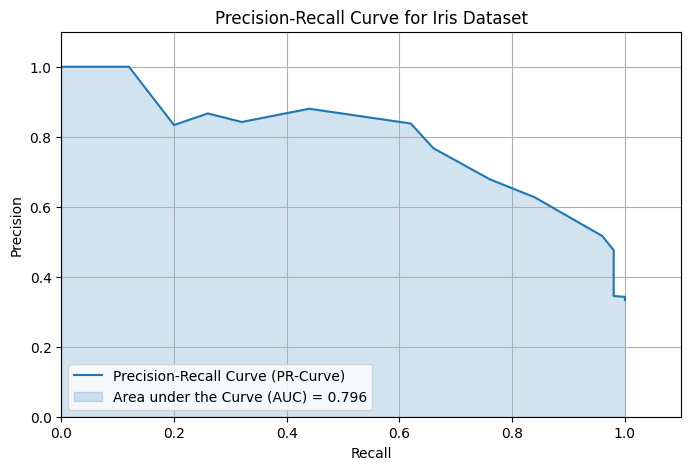

In [67]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (Virginica)
y_scores = log_reg.predict_proba(X)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, y_scores)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot PR curve and fill area under it
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color="tab:blue", label="Precision-Recall Curve (PR-Curve)")
plt.fill_between(recall, precision, alpha=0.2, color="tab:blue", label=f"Area under the Curve (AUC) = {pr_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Iris Dataset")
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
#plt.tight_layout()
plt.show()

## ROC Curve and ROC AUC

Another common performance curve is the **ROC curve (Receiver Operating Characteristic)**. It plots:

* **x-axis**: False Positive Rate = FP / (FP + TN)
* **y-axis**: True Positive Rate = Recall = TP / (TP + FN)

A **random model** gives you a diagonal line (AUC = 0.5), while a **perfect classifier** reaches the top-left corner (AUC = 1.0).

$$
\text{ROC AUC} = \text{Area under the ROC curve}
$$

ROC AUC is especially useful when **positive and negative classes are balanced**. It measures the model’s ability to **rank** positive instances higher than negatives, regardless of the threshold.


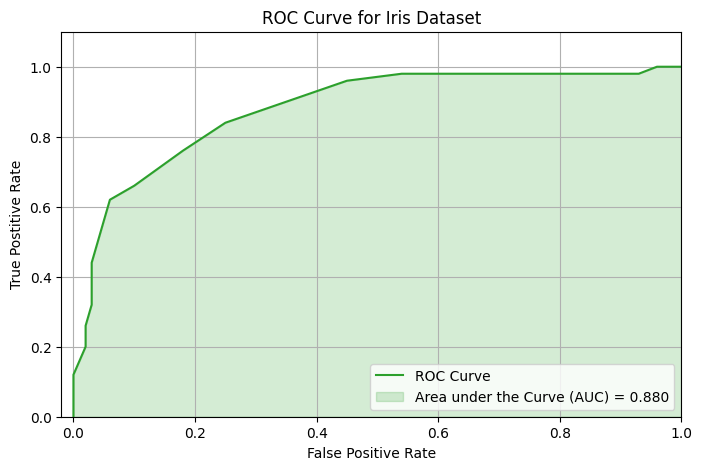

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute precision-recall curve
tpr, fpr, thresholds = roc_curve(y, y_scores)

# Compute PR AUC
pr_auc = auc(tpr, fpr)

# Plot PR curve and fill area under it
plt.figure(figsize=(8, 5))
plt.plot(tpr, fpr, color="tab:green", label="ROC Curve")
plt.fill_between(tpr, fpr, alpha=0.2, color="tab:green", label=f"Area under the Curve (AUC) = {pr_auc:.3f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Postitive Rate")
plt.title("ROC Curve for Iris Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(0, 1.1)
#plt.tight_layout()
plt.show()

## PR AUC vs. ROC AUC

To summarize, use the Precision-Recall (PR) curve when your classes are imbalanced or you care more about the positive class, as it focuses on precision and recall. This might necessitate switching which class is the positive class (spam or ham?). The ROC curve works well when classes are balanced since it treats both classes equally. In short, PR curves highlight positive-class performance, while ROC curves measure overall discrimination.

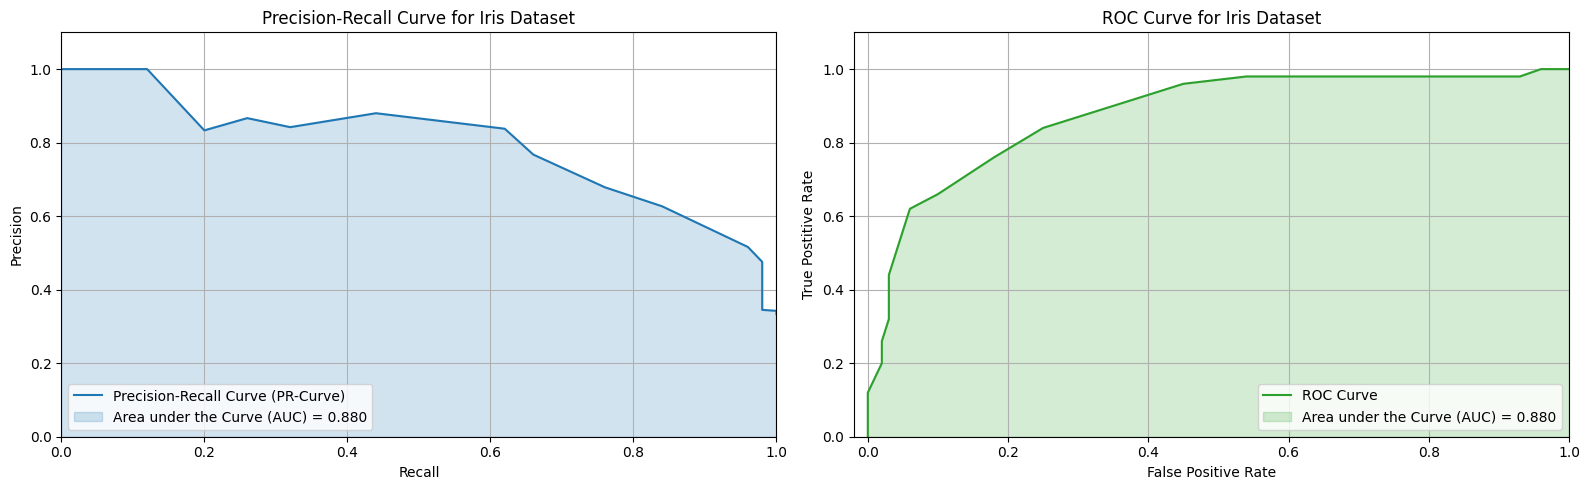

In [88]:

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color="tab:blue", label="Precision-Recall Curve (PR-Curve)")
plt.fill_between(recall, precision, alpha=0.2, color="tab:blue", label=f"Area under the Curve (AUC) = {pr_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Iris Dataset")
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(tpr, fpr, color="tab:green", label="ROC Curve")
plt.fill_between(tpr, fpr, alpha=0.2, color="tab:green", label=f"Area under the Curve (AUC) = {pr_auc:.3f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Postitive Rate")
plt.title("ROC Curve for Iris Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(0, 1.1)
plt.tight_layout()

plt.savefig("cover.png")
plt.show()